In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

In [2]:
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def read_npy(paths,sep=2):
    npys = []
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [4]:
!ls /mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-*.npy

/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-rho.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-rhop.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vp.npy
/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vrel.npy


In [5]:
tgt_vg = read_npy(['/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy'])

0:Loading /mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy (3, 256, 256, 256)
Total of 1 files loaded


In [6]:
tgt_vg = tgt_vg[0]

In [12]:
tgt_vp,unetr_vp,unetv_vp = read_npy(
    ['/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vrel.npy',
     '/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-rel-stats-trained-longer3/all-out/TurbPar.out2.00103.hdf5-vrel_out.npy',
     '/mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00103.hdf5-vp_out.npy'
    ],
)
#unetr_vp += tgt_vg
unetv_vp = unetv_vp - tgt_vg

0:Loading /mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vrel.npy (3, 256, 256, 256)
2:Loading /mnt/home/tchan1/ceph/mldust-ver2/runs/wvelc-stats/all-out/TurbPar.out2.00103.hdf5-vp_out.npy (3, 256, 256, 256)
Total of 3 files loaded


In [13]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [126]:
def plot_slice(axis,frame,ql=None,qh=None):
    frame_slice = frame[:,frame.shape[-1]//2,:]
    #eps = np.unique(frame)[1]
    #print('epsilon: ', eps)
    x,y = np.linspace(0,1,256), np.linspace(0,1,256)
    X,Y = np.meshgrid(x,y,indexing='xy')
    if ql is None or qh is None:
        ql,qh = np.quantile(frame,[0.10,0.90])
    im = axis.pcolormesh(X,Y,frame_slice,
                    #vmin=ql,vmax=qh,
                    linewidth=0, rasterized=True,shading='auto', cmap='RdBu_r',
                    norm=colors.CenteredNorm(), #colors.SymLogNorm(linthresh=0.1, linscale=0.1,
                    #vmin=-0.1, vmax=0.1 #, base=10)
                    #vmin=ql,vmax=qh
                    #norm = colors.Normalize(vmin=ql,vmax=qh)
                    #norm=colors.LogNorm(vmin=ql, vmax=qh)
                   )
    print(ql,qh)
    axis.set_aspect(1)
    #forceAspect(axis)
    #print(axis.get_images())
    return ql, qh, im
    #ax.set_axis_off()

In [163]:
plot_specs =dict(
    nrows=3,
    ncols=3,
    figsize=(10,9),
    sharey='row',sharex='col',
    constrained_layout=True,
    dpi=600
)

In [164]:
vrel = dict(
    tgt=dict(),
    unetv=dict(),
    unetr=dict()
)

In [165]:
field_names = ['tgt','unetv','unetr']
direction_names = ['x1','x2','x3']

In [166]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805
-0.05809788033366203 0.05890595354139805


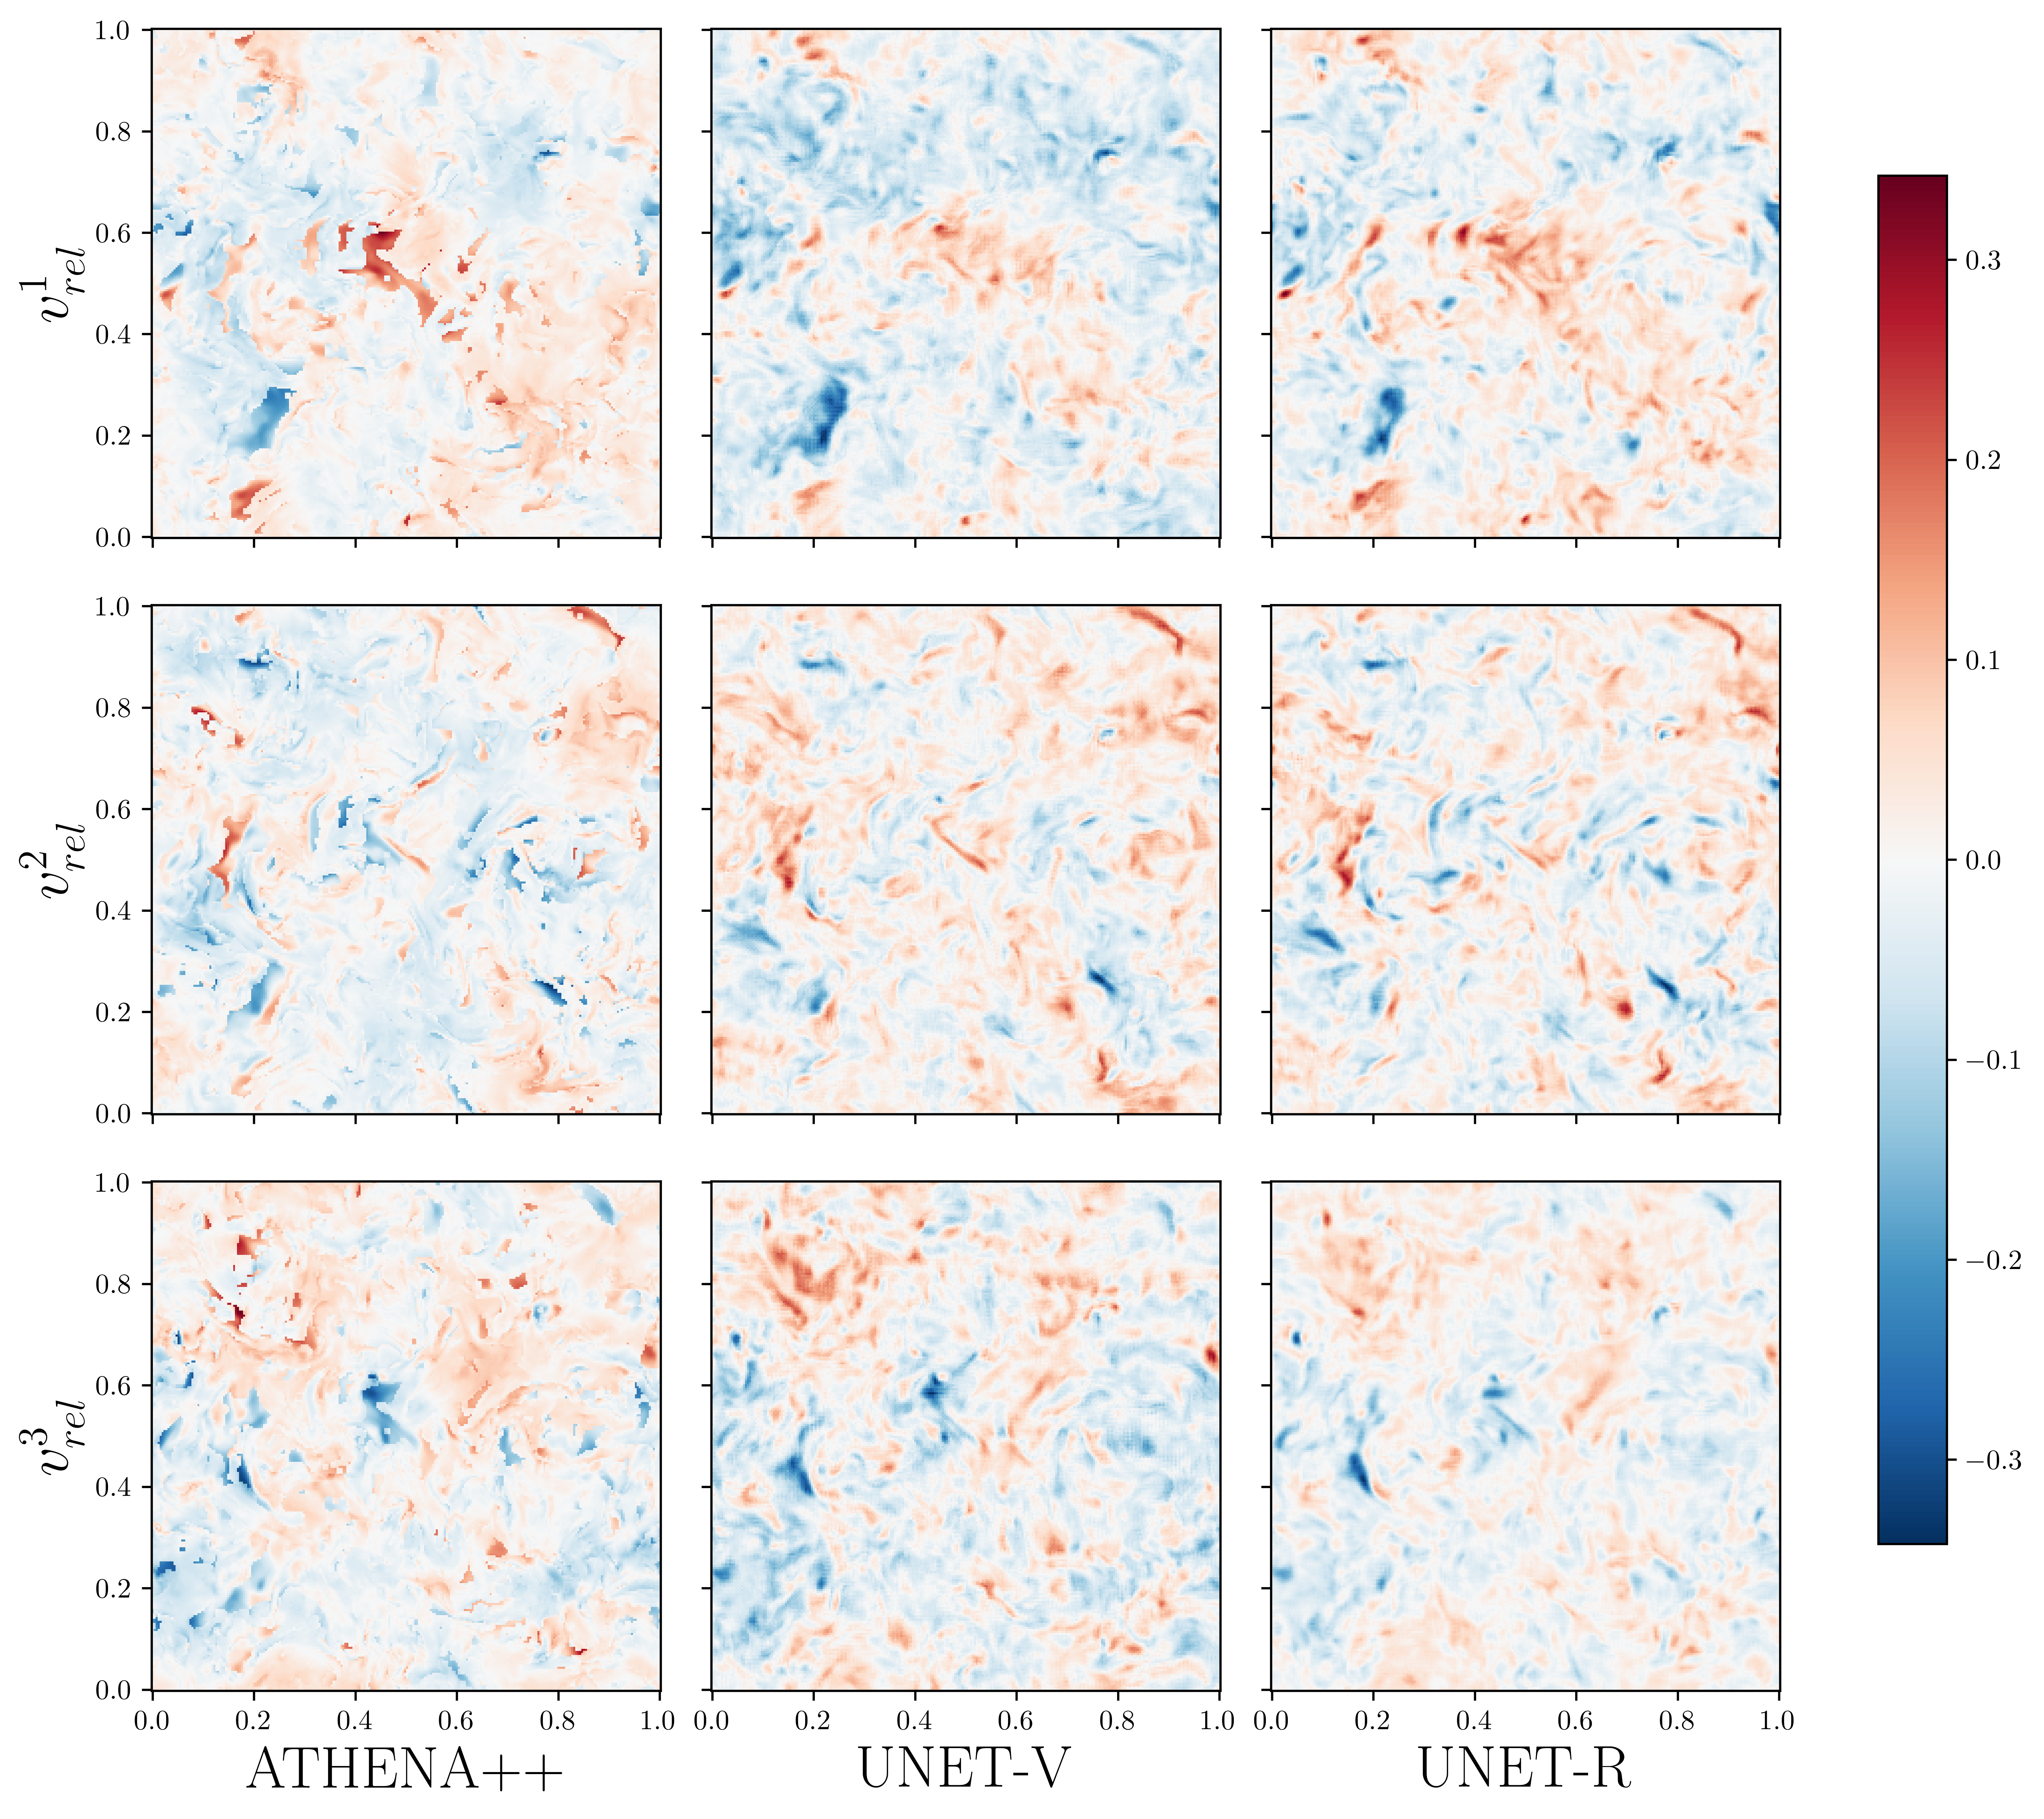

In [169]:
with PdfPages('velc_slice_comp.pdf') as pdf:
    fig, axs = plt.subplots(**plot_specs)


    for n, field in enumerate([tgt_vp,unetv_vp,unetr_vp]):
        for i in range(3): # vx,vy,vz
            if i == 0 and n == 0:
                ql,qh,_ = plot_slice(axs[i][n],field[i])
            else:
                _,_, im = plot_slice(axs[i][n],field[i],ql=ql,qh=qh)

            hist = np.histogram(field[i]-tgt_vp[i],bins=100,density=True)
            vrel[field_names[n]][direction_names[i]] = dict(
                binEdges = hist[1],
                density  = hist[0],
                binCenters = 0.5*(hist[1][1:] + hist[1][:-1])
            )

    #print(axs.shape)
    fig.colorbar(im, ax=axs.ravel().tolist(),shrink=0.8)

    # Set y labels
    axs[0][0].set_ylabel(r'$v_{rel}^{1}$',fontsize=21)
    axs[1][0].set_ylabel(r'$v_{rel}^{2}$',fontsize=21)
    axs[2][0].set_ylabel(r'$v_{rel}^{3}$',fontsize=21)

    # Set x labels
    axs[2][0].set_xlabel('ATHENA++',fontsize=21)
    axs[2][1].set_xlabel('UNET-V',fontsize=21)
    axs[2][2].set_xlabel('UNET-R',fontsize=21)
    
    pdf.savefig(fig)

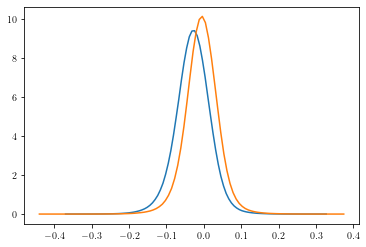

In [168]:
#plt.plot(vrel['tgt']['x1']['binCenters'],vrel['tgt']['x1']['density'])
plt.plot(vrel['unetv']['x1']['binCenters'],vrel['unetv']['x1']['density'])
plt.plot(vrel['unetr']['x1']['binCenters'],vrel['unetr']['x1']['density'])
#plt.yscale('log')
#plt.xscale('symlog')
#plt.xlim(-0.1,0.1)